In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Camera Calibration

Text(0.5,1,'Undistorted Image')

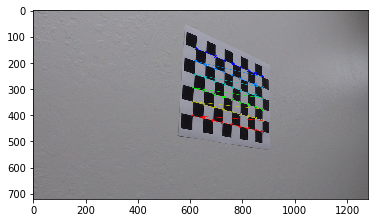

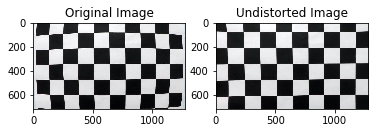

In [2]:
import glob
images = glob.glob('./camera_cal/calibration*.jpg')
objpoints=[] #3d points in real world space
imgpoints=[] #2d points in image plane
#Prepare object points like (0,0,0)...(8,5,0)
objp = np.zeros((6*9,3),np.float32)
objp[:,:2]= np.mgrid[0:9,0:6].T.reshape(-1,2)
for fname in images:
    img = mpimg.imread(fname)
    #Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #Find the chessboard corneers
    ret,corners=cv2.findChessboardCorners(gray,(9,6),None)
    #If corners found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        plt.imshow(img)

#Camera Calibration
ret,mtx,dist,rvecs,tvecs= cv2.calibrateCamera(objpoints,
                                             imgpoints,gray.shape[::-1],
                                             None,None)

# #Visualize undistortion on any 1 chessboard image
img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img,mtx,dist,None,mtx)
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(dst)
ax2.set_title('Undistorted Image')


# Visualize Undistortion

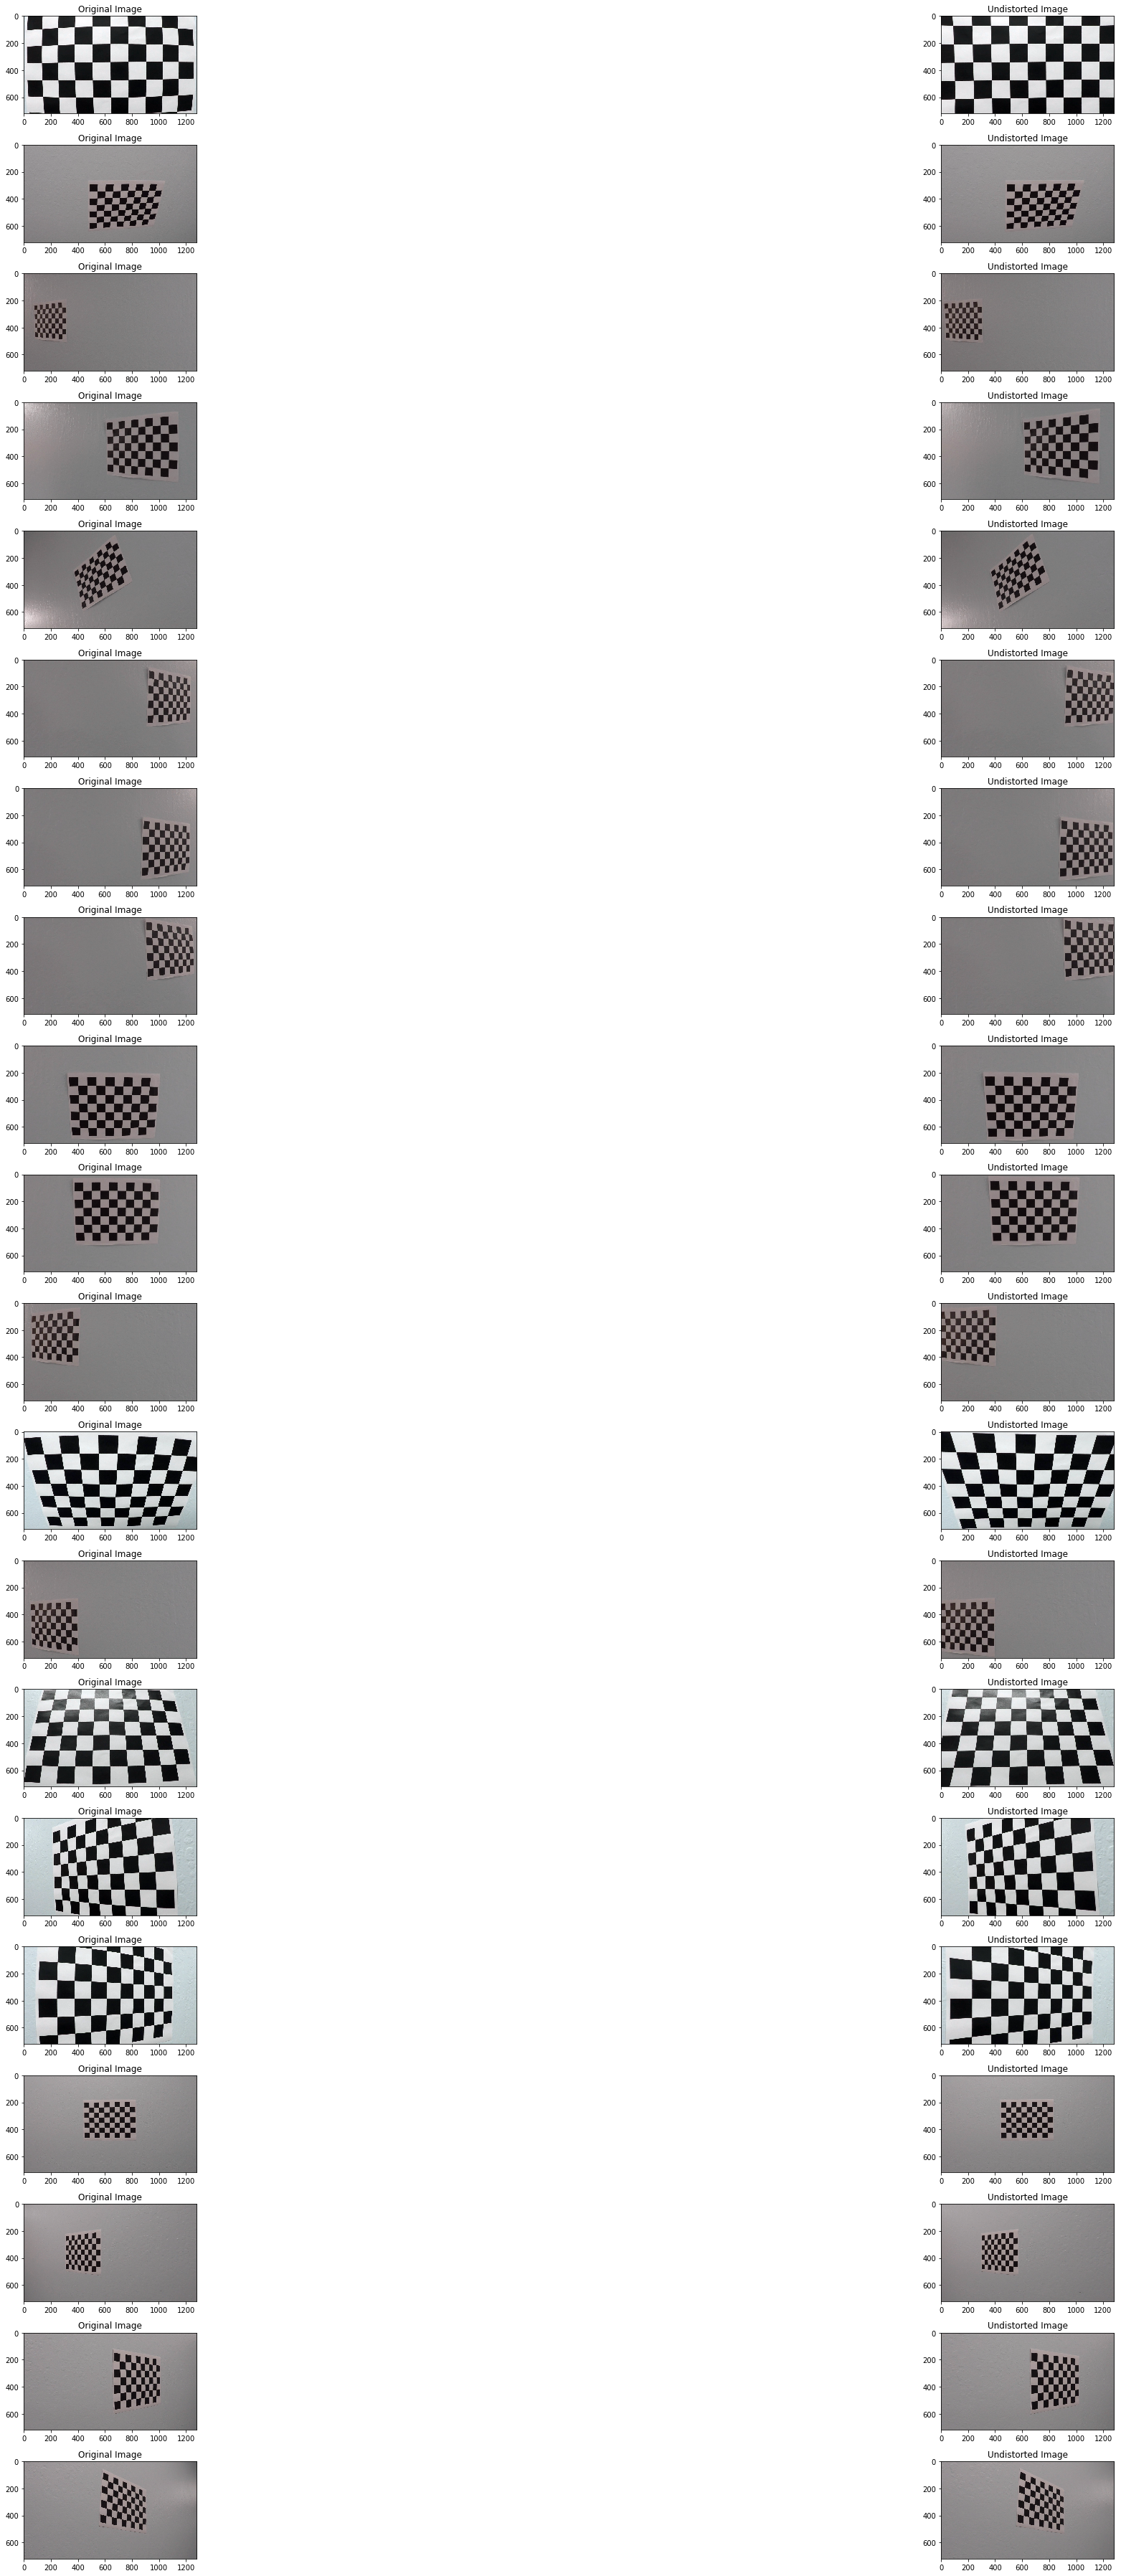

In [3]:
undist=[]
for i in range(len(images)):
    img = cv2.imread(images[i])
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    undist.append(dst)
    

f , ax = plt.subplots(len(undist),2,figsize=(50,50))
ax=ax.ravel()
j=0
for i in range(0,len(ax)):
    if i%2==0:
        ax[i].set_title('Original Image')
        ax[i].imshow(cv2.imread(images[j]))
    else:
        ax[i].set_title('Undistorted Image')
        ax[i].imshow(undist[j],cmap='gray')        
        j=j+1
f.tight_layout()
plt.show()

### Perspective Trasformation

Text(0.5,1,'Undistorted & Perspective Transformed Image')

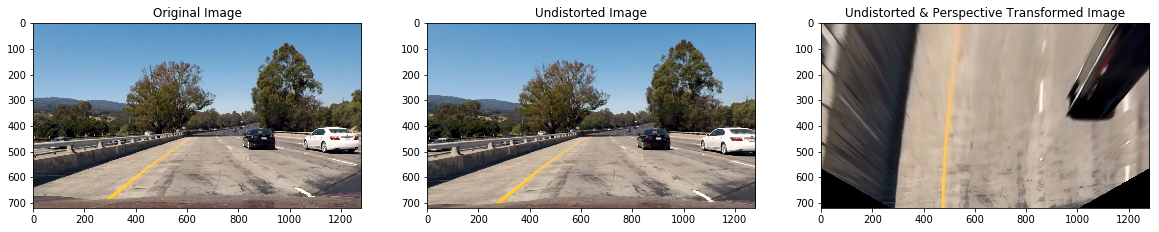

In [4]:
def warp(img):
    img_size =(img.shape[1],img.shape[0])
    src = np.float32([(296,634),(995,634),(716,461),(559,461)])
    dst = np.float32([(440,720),(840,720),(840,0),(440,0)])
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped, M, M_inv
def undistort(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

#Vizualizing undistortion and perspective transform on test image
test_img = cv2.imread('./test_images/test1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undist_test_img = undistort(test_img)
warped_im,_,_ = warp(undist_test_img)

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,20))
ax1.imshow(test_img)
ax1.set_title('Original Image')
ax2.imshow(undist_test_img)
ax2.set_title('Undistorted Image')
ax3.imshow(warped_im)
ax3.set_title('Undistorted & Perspective Transformed Image')

### Sobel Operator and Gradient Thresholding

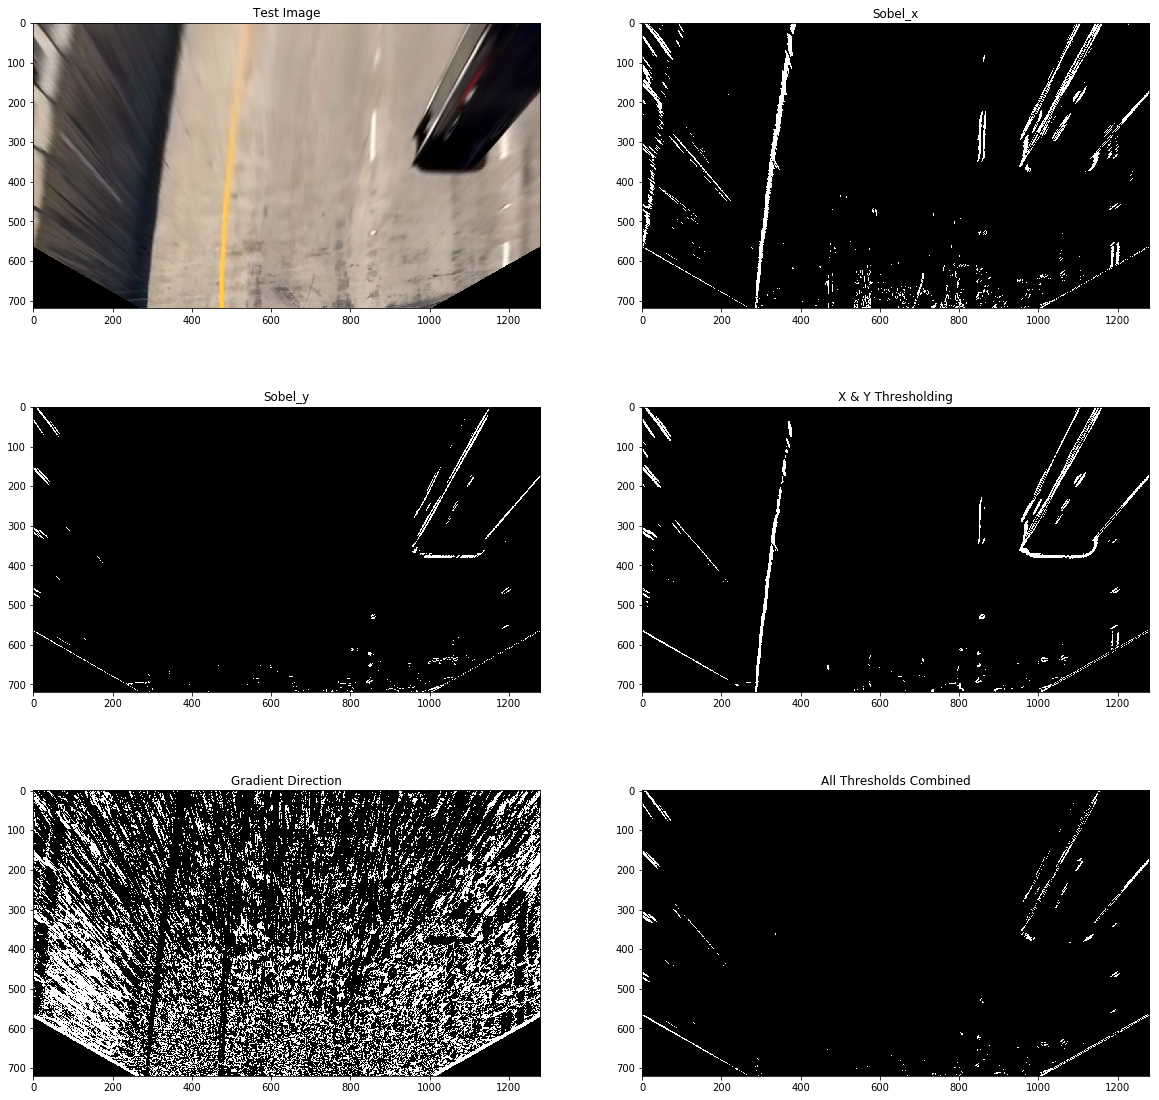

In [5]:
def abs_sobel_thresh(img,orient,thresh_min,thresh_max):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel= cv2.Sobel(gray,cv2.CV_64F,1,0)
    if orient == 'y':
        sobel= cv2.Sobel(gray,cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary=np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel>=thresh_min)&(scaled_sobel<=thresh_max)]=1
    return sxbinary

def mag_thresh(img,sobel_kernel, mag_thresh):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx= cv2.Sobel(gray,cv2.CV_64F,1,0,ksize= sobel_kernel)
    sobely= cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    gradmag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag>=mag_thresh[0]) & (gradmag<=mag_thresh[1])]=1
    return binary_output

def dir_thresh(img,sobel_kernel,thresh):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize= sobel_kernel)
    sobely= cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    absgraddir=np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir>=thresh[0])&(absgraddir<=thresh[1])]=1
    return binary_output

def combine_thresh(sobelx,sobely,mag_binary,dir_binary):
    combined = np.zeros_like(dir_binary)
    combined[((sobelx==1)&(sobely==1))|((mag_binary==1)&(dir_binary==1))]=1
    return combined

#Calculate Thresholding 
sobelx= abs_sobel_thresh(warped_im,'x',20,100)
sobely= abs_sobel_thresh(warped_im,'y',20,100)
mag_binary = mag_thresh(warped_im,sobel_kernel=9,mag_thresh=(30,100))
dir_binary = dir_thresh(warped_im,sobel_kernel=9,thresh=(0.7,1.3))
combined = combine_thresh(sobelx,sobely,mag_binary,dir_binary)

#Visualize Thresholding 
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(warped_im)
plt.title('Test Image')
plt.subplot(322)
plt.imshow(sobelx,cmap='gray')
plt.title('Sobel_x')
plt.subplot(323)
plt.imshow(sobely,cmap='gray')
plt.title('Sobel_y')
plt.subplot(324)
plt.imshow(mag_binary,cmap='gray')
plt.title('X & Y Thresholding')
plt.subplot(325)
plt.imshow(dir_binary,cmap='gray')
plt.title('Gradient Direction')
plt.subplot(326)
plt.imshow(combined,cmap='gray')
plt.title('All Thresholds Combined')
plt.savefig('edge_expt.png')
plt.show()

### Color Spaces

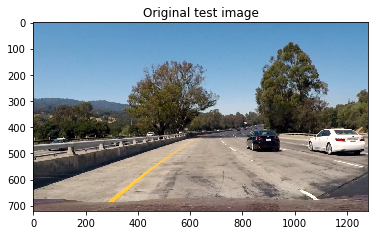

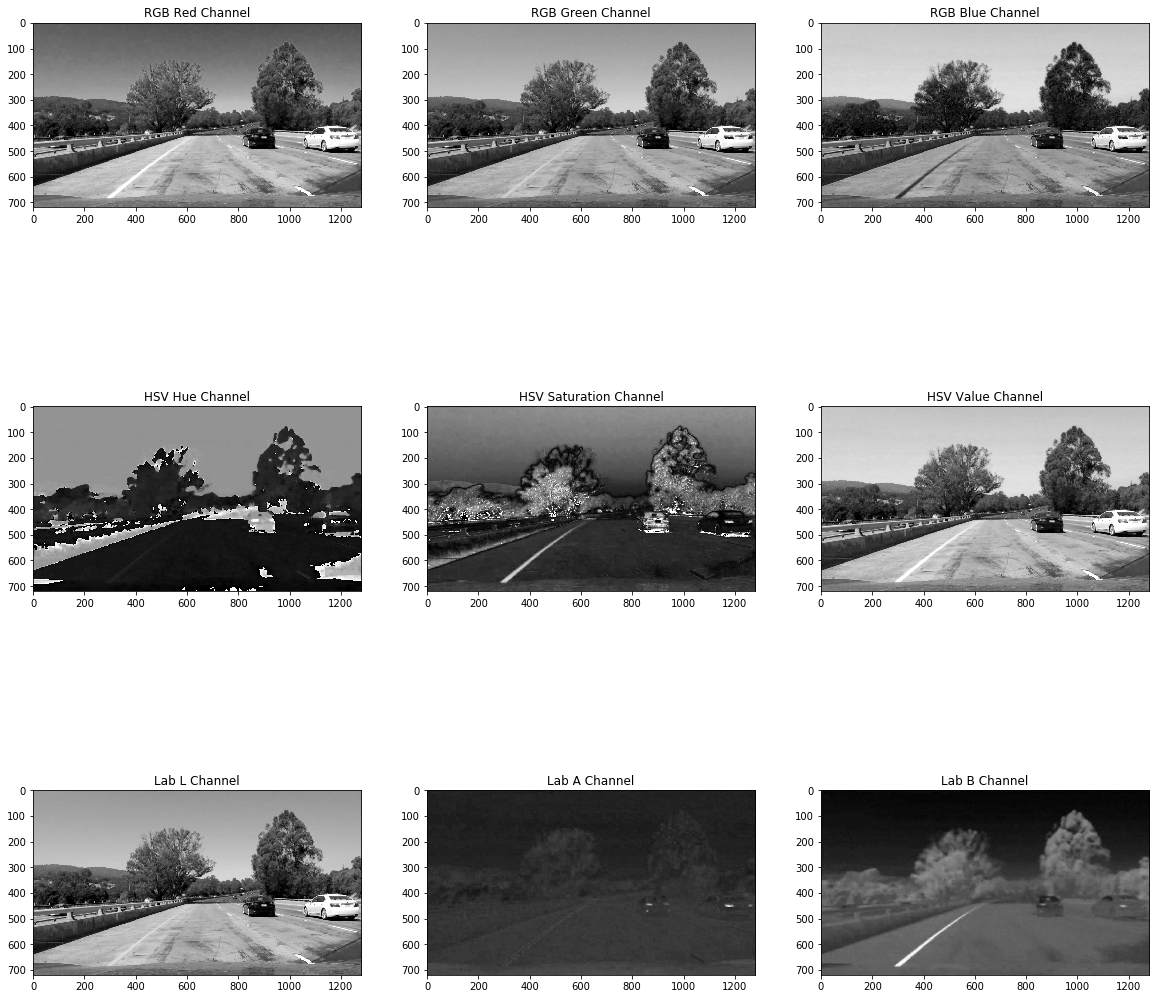

In [6]:
def seperate_channels(image):
    #Separate channels in various color spaces
    R=image[:,:,0]
    G=image[:,:,1]
    B=image[:,:,2]
    image_HSV= cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    H = image_HSV[:,:,0]
    S= image_HSV[:,:,1]
    V= image_HSV[:,:,2]
    image_LAB = cv2.cvtColor(image,cv2.COLOR_RGB2Lab)
    L = image_LAB[:,:,0]
    A = image_LAB[:,:,1]
    b =  image_LAB[:,:,2]
    return R,G,B,H,S,V,L,A,b

#Read Image
image = test_img
#Visualize
R,G,B,H,S,V,L,A,b= seperate_channels(image)
plt.imshow(image)
plt.title('Original test image')
fig, axes = plt.subplots(3,3,figsize=(20,20))
axes[0,0].imshow(R,cmap='gray')
axes[0,0].set_title('RGB Red Channel')
axes[0,1].imshow(G,cmap='gray')
axes[0,1].set_title('RGB Green Channel')
axes[0,2].imshow(B,cmap='gray')
axes[0,2].set_title('RGB Blue Channel')
axes[1,0].imshow(H,cmap='gray')
axes[1,0].set_title('HSV Hue Channel')
axes[1,1].imshow(S,cmap='gray')
axes[1,1].set_title('HSV Saturation Channel')
axes[1,2].imshow(V,cmap='gray')
axes[1,2].set_title('HSV Value Channel')
axes[2,0].imshow(L,cmap='gray')
axes[2,0].set_title('Lab L Channel')
axes[2,1].imshow(A,cmap='gray')
axes[2,1].set_title('Lab A Channel')
axes[2,2].imshow(b,cmap='gray')
axes[2,2].set_title('Lab B Channel')
plt.savefig('color_expt.png')

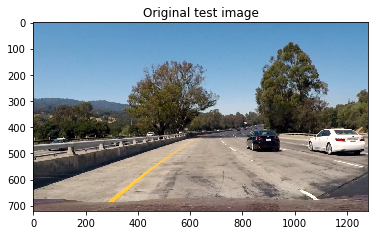

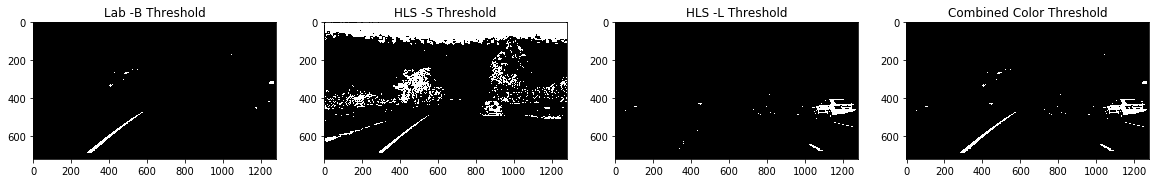

In [7]:
def convert2_8bit(image):
    image_8bit = image*(255/np.max(image))
    return image_8bit
def colorThresh(image, thresh, color_space):
    #image is seperated color channel single channel image
    min_thresh = thresh[0]
    max_thresh = thresh[1]
    if color_space=='lab':
        if np.max(image)>175:
            image_8bit = convert2_8bit(image)
        else:
            image_8bit = image
    else:
        #Convert to 8 bit image
        image_8bit = convert2_8bit(image)
    binary_output = np.zeros_like(image_8bit)
    binary_output[(image_8bit>min_thresh)&(image_8bit<=max_thresh)]=1
    return binary_output

def combineColorThresh(lab_b,hls_s,hls_l):
    combined_color = np.zeros_like(lab_b)
    combined_color[(lab_b==1)|(hls_l==1)]=1
    return combined_color

lab_bthresh= colorThresh(b,(190,255),'lab')
hls_sthresh = colorThresh(S,(125,255),'hls')
hls_lthresh = colorThresh(L,(220,255),'hls')
combined = combineColorThresh(lab_bthresh,hls_sthresh,hls_lthresh)

#Visualize Threshold Images
plt.imshow(image)
plt.title('Original test image')
fig,(ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(20,20))
ax1.imshow(lab_bthresh,cmap='gray')
ax1.set_title('Lab -B Threshold')
ax2.imshow(hls_sthresh,cmap='gray')
ax2.set_title('HLS -S Threshold')
ax3.imshow(hls_lthresh,cmap='gray')
ax3.set_title('HLS -L Threshold')
ax4.imshow(combined,cmap='gray')
ax4.set_title('Combined Color Threshold')
plt.savefig('color_thresh.png')

## Pipeline

In [8]:
def pipeline(image):
#     sobelx= abs_sobel_thresh(warped_im,'x',20,100)
#     sobely= abs_sobel_thresh(warped_im,'y',20,100)
#     mag_binary = mag_thresh(warped_im,sobel_kernel=9,mag_thresh=(30,100))
#     dir_binary = dir_thresh(warped_im,sobel_kernel=9,thresh=(0.7,1.3))
#     combined = combine_thresh(sobelx,sobely,mag_binary,dir_binary)
    R,G,B,H,S,V,L,A,b= seperate_channels(image)
    lab_bthresh= colorThresh(b,(190,255),'lab')
    hls_sthresh = colorThresh(S,(125,255),'hls')
    hls_lthresh = colorThresh(L,(220,255),'hls')
    combined_color = combineColorThresh(lab_bthresh,hls_sthresh,hls_lthresh)
    undistorted_img = undistort(combined_color)
    warped_im,M,M_inv = warp(undistorted_img)
    return warped_im,combined_color,M,M_inv


# res = pipeline(test_img)
# plt.imshow(res,cmap='gray')

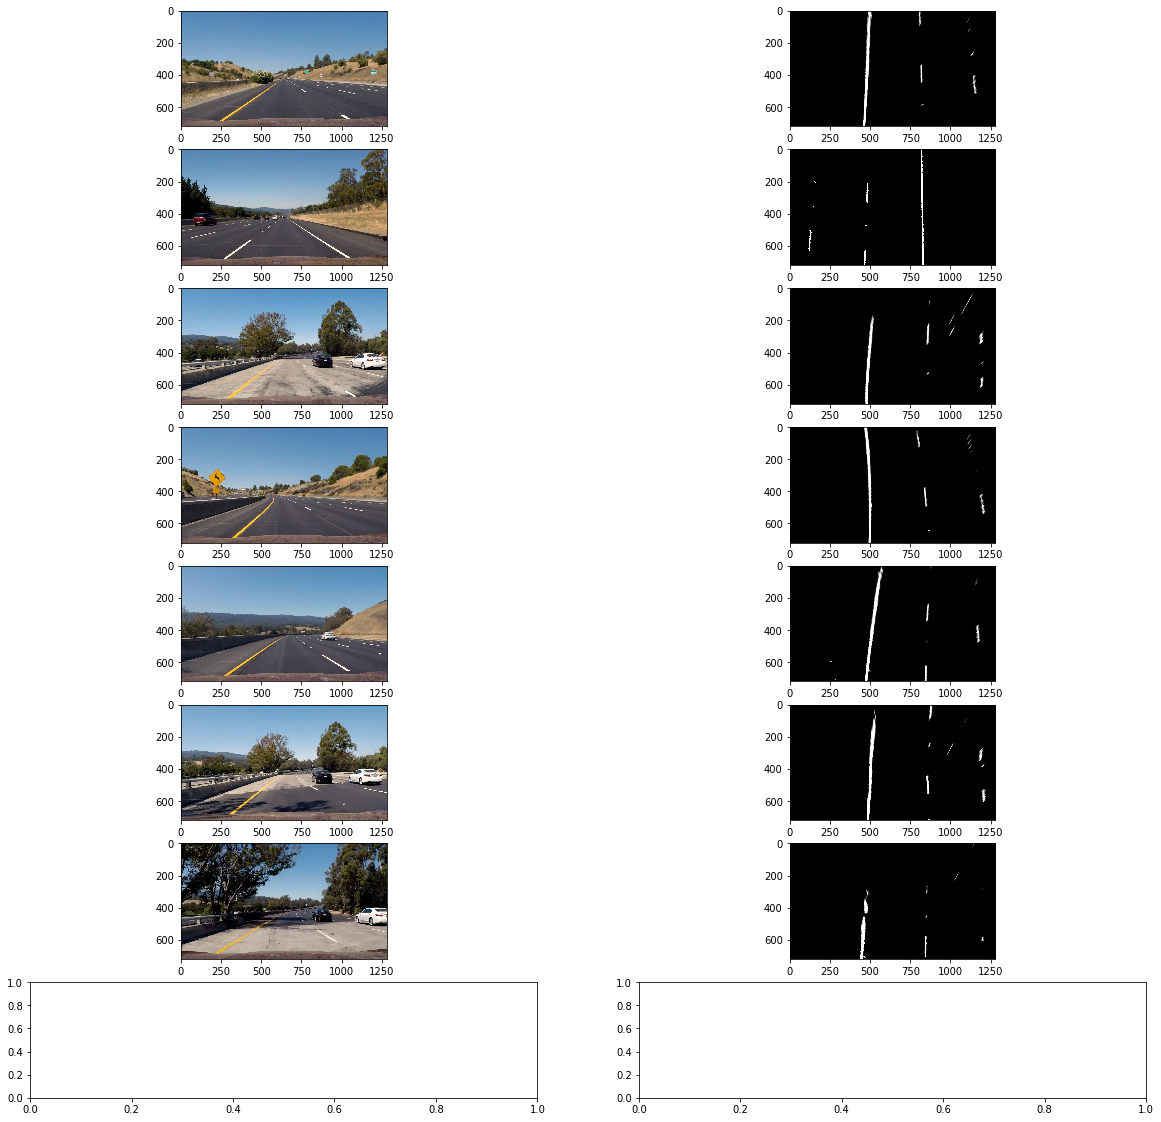

In [9]:
images = glob.glob('./test_images/*.jpg')
images_count = len(images)
fig,axes = plt.subplots(images_count,2,figsize=(20,20))
axes=axes.ravel()
j=0
for i in range(images_count-1):
    img = mpimg.imread(images[i])
    res,_,_,_= pipeline(img)
    axes[j].imshow(img)
    axes[j+1].imshow(res,cmap='gray')
    j=j+2


# Sliding Window

In [10]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
exampleImg = cv2.imread('./test_images/test5.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin,c,M, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('win.png')

NameError: name 'sliding_window_polyfit' is not defined

# Histogram

In [ ]:
plt.plot(histogram)
plt.xlim(0, 1280)
plt.savefig('hist.png')

# Polyfit leveraging from previous frame

In [ ]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin,c,M, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('polyfit.png')

# Calculating Radius of Curvature of lane lines and center offset from lane line

In [ ]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

In [ ]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv,curv_rad,center_dist):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'+' Center Offset: '+'{:04.2f}'.format(center_dist)
    cv2.putText(result, text, (40,70),  cv2.FONT_HERSHEY_DUPLEX, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv,(rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out1)
plt.savefig('roc.png')

In [ ]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

In [ ]:
def process_image(img):
    new_img = np.copy(img)
    img_bin,c,M, Minv = pipeline(new_img)
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_fit, r_fit, 
                                                               l_lane_inds, r_lane_inds)
    img_out1 = draw_lane(new_img, img_bin, l_fit, r_fit, Minv,(rad_l+rad_r)/2,d_center)
    return img_out1

In [ ]:
from moviepy.editor import VideoFileClip

l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)